In [ ]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

In [ ]:
# download SDXL Lightning model
!wget https://huggingface.co/ByteDance/SDXL-Lightning/resolve/main/sdxl_lightning_2step_unet.safetensors

--2024-03-08 15:10:18--  https://huggingface.co/ByteDance/SDXL-Lightning/resolve/main/sdxl_lightning_2step_unet.safetensors
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.17, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/ae/a8/aea888ce05627728879b1954083956ea29cc3158dcdb28c0b7e3e8283ca1fa96/15a96a3b213b8b4d6ea720b4fa5bf6723cd877170bd1a90f58e34da2968ef854?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sdxl_lightning_2step_unet.safetensors%3B+filename%3D%22sdxl_lightning_2step_unet.safetensors%22%3B&Expires=1710169818&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDE2OTgxOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2FlL2E4L2FlYTg4OGNlMDU2Mjc3Mjg4NzliMTk1NDA4Mzk1NmVhMjljYzMxNThkY2RiMjhjMGI3ZTNlODI4M2NhMWZhOTYvMTVhOTZhM2

In [ ]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Load model
unet = UNet2DConditionModel.from_config(model_id, subfolder="unet").to("cuda", torch.float16)

unet.load_state_dict(load_file("sdxl_lightning_2step_unet.safetensors", device="cuda"))

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all o

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained(model_id,
                                                 unet=unet,
                                                 torch_dtype=torch.float16,
                                                 variant="fp16").to("cuda")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Ensure sampler uses "trailing" timesteps
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

In [ ]:
# image generation
prompt = "generate a portfolio home page for a girl web developer with 1 year experience"

image = pipe(prompt,
             num_inference_steps=2,
             width = 1024,
             height = 1024,
             guidance_scale=0).images[0]

  0%|          | 0/2 [00:00<?, ?it/s]

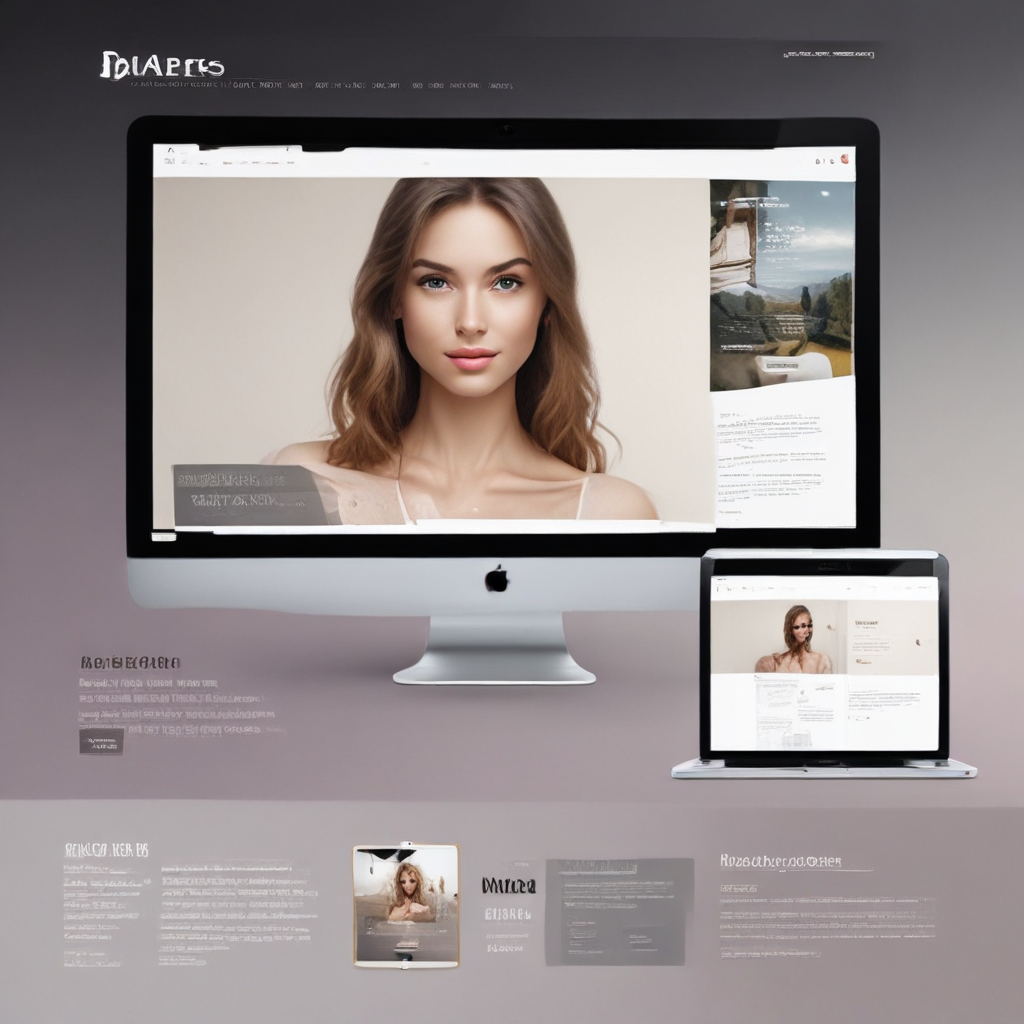

In [ ]:

# display generated image
image